In [17]:
from utilities import *
from models import *
import os
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix,  roc_curve, roc_auc_score, auc, ConfusionMatrixDisplay
import numpy as np
from tqdm import tqdm

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'gpu'

In [32]:
model = ImprovedAutoencoder()
model_path = "trained_models/autoencoder_model_large_better.pth"
model.load_state_dict(torch.load(model_path))
transform = get_transform()
model = model.to(device)

In [33]:
class TestImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

In [34]:
# Create instances of your custom dataset
normal_dataset = TestImageDataset(root_dir='data/new_test_data/normal', transform=transform)
anomalous_dataset = TestImageDataset(root_dir='data/new_test_data/anomaly', transform=transform)

In [35]:
normal_loader = DataLoader(normal_dataset, batch_size=32, shuffle=False)
anomalous_loader = DataLoader(anomalous_dataset, batch_size=32, shuffle=False)

In [36]:
criterion = nn.MSELoss()

In [37]:
from sklearn.metrics import classification_report

def generate_metrics(model, criterion, device, normal_loader, anomalous_loader, threshold=0.0038):
    y_true = []
    y_scores = []
    model.eval()

    with torch.no_grad():  # Use torch.no_grad() for evaluation
        for inputs in normal_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            y_true.extend([0] * len(inputs))  # 0 means not anomalous
            y_scores.extend([loss.item()] * len(inputs))  # loss as anomaly score

        for inputs in anomalous_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            y_true.extend([1] * len(inputs))  # 1 means anomalous
            y_scores.extend([loss.item()] * len(inputs))  # loss as anomaly score

    # ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Classification Report
    y_pred = [1 if score > threshold else 0 for score in y_scores]
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Anomalous']))

    # Individual Metrics
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    conf_mat = confusion_matrix(y_true, y_pred)

    return conf_mat, precision, recall, f1

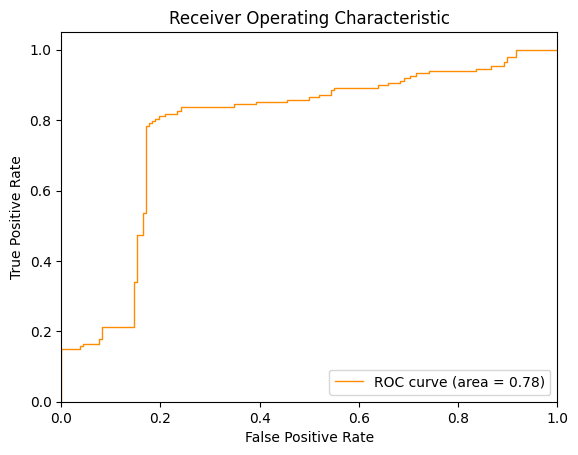

              precision    recall  f1-score   support

      Normal       0.80      0.82      0.81      5054
   Anomalous       0.81      0.78      0.80      4749

    accuracy                           0.80      9803
   macro avg       0.80      0.80      0.80      9803
weighted avg       0.80      0.80      0.80      9803

Precision: 0.8061025752001731
Recall: 0.7843756580332701
F1 Score: 0.7950907150480256


In [41]:
cm_current, precision_current, recall_current, f1_current = generate_metrics(model, criterion, device, normal_loader, anomalous_loader)

In [42]:
cm_current

array([[4158,  896],
       [1024, 3725]], dtype=int64)

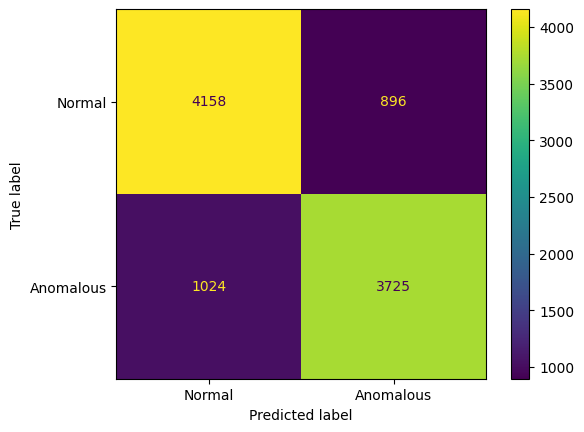

In [43]:
matrix_plot = ConfusionMatrixDisplay(cm_current,display_labels=["Normal", "Anomalous"])
matrix_plot.plot()

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluating model with threshold: 0.002


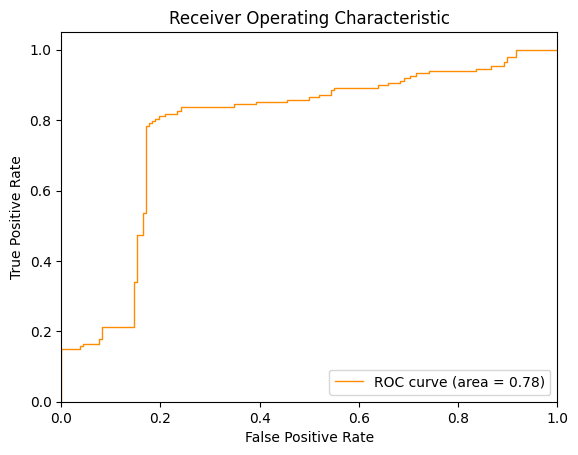

  5%|▌         | 1/20 [00:14<04:27, 14.08s/it]

              precision    recall  f1-score   support

      Normal       0.87      0.08      0.15      5054
   Anomalous       0.50      0.99      0.67      4749

    accuracy                           0.52      9803
   macro avg       0.68      0.53      0.41      9803
weighted avg       0.69      0.52      0.40      9803

Precision: 0.5025206478601308
Recall: 0.9865234786270793
F1 Score: 0.6658612848209209
Confusion Matrix: 
[[ 416 4638]
 [  64 4685]]
Precision: 0.5025206478601308
Recall: 0.9865234786270793
F1 Score: 0.6658612848209209
Accuracy: 0.5203509129858207
---------
Evaluating model with threshold: 0.002131578947368421


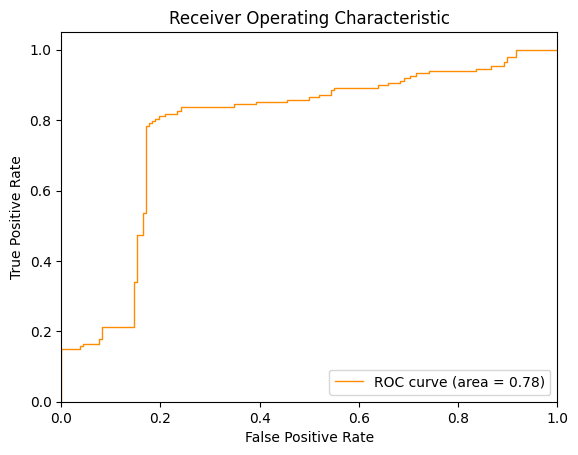

 10%|█         | 2/20 [00:28<04:18, 14.34s/it]

              precision    recall  f1-score   support

      Normal       0.72      0.11      0.20      5054
   Anomalous       0.50      0.95      0.66      4749

    accuracy                           0.52      9803
   macro avg       0.61      0.53      0.43      9803
weighted avg       0.61      0.52      0.42      9803

Precision: 0.5026102410307676
Recall: 0.9528321751947778
F1 Score: 0.6580860965677721
Confusion Matrix: 
[[ 576 4478]
 [ 224 4525]]
Precision: 0.5026102410307676
Recall: 0.9528321751947778
F1 Score: 0.6580860965677721
Accuracy: 0.5203509129858207
---------
Evaluating model with threshold: 0.002263157894736842


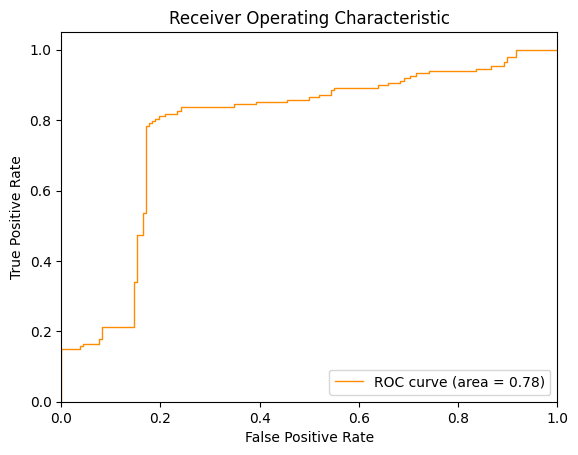

 15%|█▌        | 3/20 [00:43<04:04, 14.38s/it]

              precision    recall  f1-score   support

      Normal       0.74      0.16      0.27      5054
   Anomalous       0.51      0.94      0.66      4749

    accuracy                           0.54      9803
   macro avg       0.63      0.55      0.47      9803
weighted avg       0.63      0.54      0.46      9803

Precision: 0.5137625244731083
Recall: 0.9393556538218573
F1 Score: 0.6642346634901727
Confusion Matrix: 
[[ 832 4222]
 [ 288 4461]]
Precision: 0.5137625244731083
Recall: 0.9393556538218573
F1 Score: 0.6642346634901727
Accuracy: 0.5399367540548812
---------
Evaluating model with threshold: 0.002394736842105263


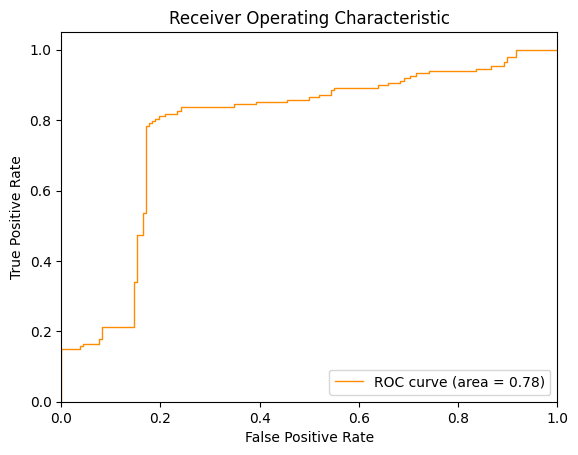

 20%|██        | 4/20 [00:57<03:49, 14.36s/it]

              precision    recall  f1-score   support

      Normal       0.80      0.23      0.36      5054
   Anomalous       0.54      0.94      0.68      4749

    accuracy                           0.58      9803
   macro avg       0.67      0.59      0.52      9803
weighted avg       0.67      0.58      0.52      9803

Precision: 0.5354699315808427
Recall: 0.9393556538218573
F1 Score: 0.6821100917431193
Confusion Matrix: 
[[1184 3870]
 [ 288 4461]]
Precision: 0.5354699315808427
Recall: 0.9393556538218573
F1 Score: 0.6821100917431193
Accuracy: 0.5758441293481588
---------
Evaluating model with threshold: 0.0025263157894736842


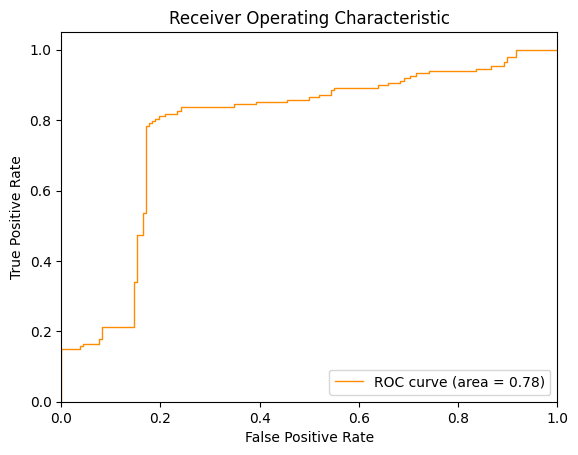

 25%|██▌       | 5/20 [01:12<03:40, 14.67s/it]

              precision    recall  f1-score   support

      Normal       0.80      0.28      0.42      5054
   Anomalous       0.55      0.93      0.69      4749

    accuracy                           0.60      9803
   macro avg       0.68      0.61      0.55      9803
weighted avg       0.68      0.60      0.55      9803

Precision: 0.5487333083738924
Recall: 0.9258791324489366
F1 Score: 0.6890769471869613
Confusion Matrix: 
[[1438 3616]
 [ 352 4397]]
Precision: 0.5487333083738924
Recall: 0.9258791324489366
F1 Score: 0.6890769471869613
Accuracy: 0.5952259512394165
---------
Evaluating model with threshold: 0.002657894736842105


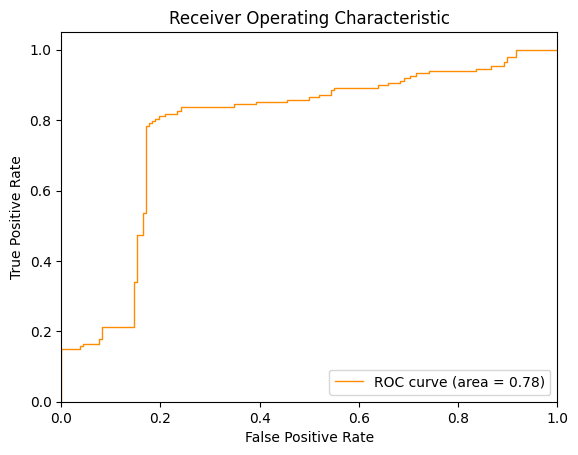

 30%|███       | 6/20 [01:27<03:24, 14.63s/it]

              precision    recall  f1-score   support

      Normal       0.78      0.32      0.45      5054
   Anomalous       0.55      0.91      0.69      4749

    accuracy                           0.60      9803
   macro avg       0.67      0.61      0.57      9803
weighted avg       0.67      0.60      0.57      9803

Precision: 0.5544669330926905
Recall: 0.9056643503895557
F1 Score: 0.6878298416759955
Confusion Matrix: 
[[1598 3456]
 [ 448 4301]]
Precision: 0.5544669330926905
Recall: 0.9056643503895557
F1 Score: 0.6878298416759955
Accuracy: 0.6017545649291033
---------
Evaluating model with threshold: 0.002789473684210526


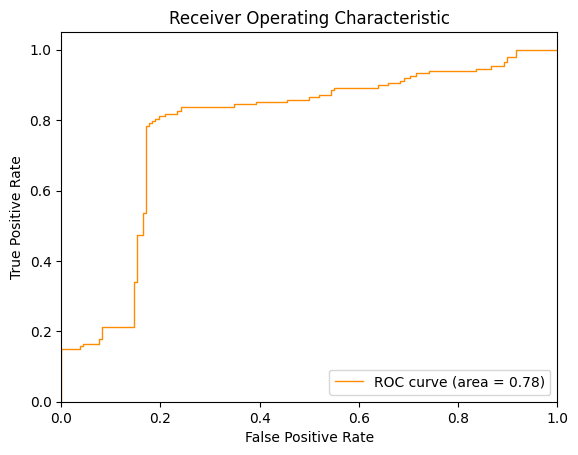

 35%|███▌      | 7/20 [01:42<03:12, 14.84s/it]

              precision    recall  f1-score   support

      Normal       0.80      0.40      0.54      5054
   Anomalous       0.58      0.89      0.71      4749

    accuracy                           0.64      9803
   macro avg       0.69      0.65      0.62      9803
weighted avg       0.70      0.64      0.62      9803

Precision: 0.5848171152518978
Recall: 0.8921878290166351
F1 Score: 0.7065199266299816
Confusion Matrix: 
[[2046 3008]
 [ 512 4237]]
Precision: 0.5848171152518978
Recall: 0.8921878290166351
F1 Score: 0.7065199266299816
Accuracy: 0.6409262470672243
---------
Evaluating model with threshold: 0.002921052631578947


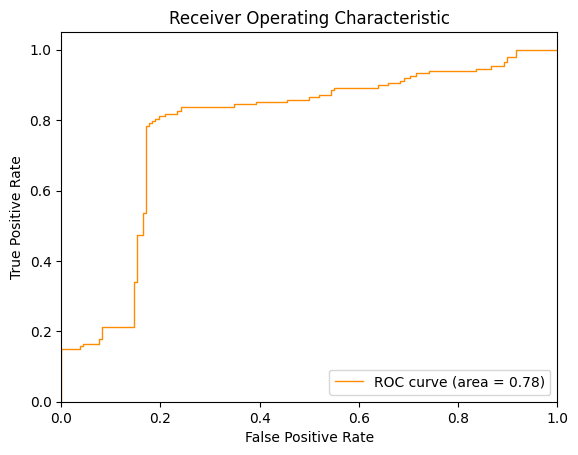

 40%|████      | 8/20 [01:57<03:00, 15.03s/it]

              precision    recall  f1-score   support

      Normal       0.80      0.46      0.58      5054
   Anomalous       0.60      0.88      0.71      4749

    accuracy                           0.66      9803
   macro avg       0.70      0.67      0.65      9803
weighted avg       0.70      0.66      0.65      9803

Precision: 0.6025992779783393
Recall: 0.8787113076437144
F1 Score: 0.7149220489977728
Confusion Matrix: 
[[2302 2752]
 [ 576 4173]]
Precision: 0.6025992779783393
Recall: 0.8787113076437144
F1 Score: 0.7149220489977728
Accuracy: 0.6605120881362848
---------
Evaluating model with threshold: 0.0030526315789473684


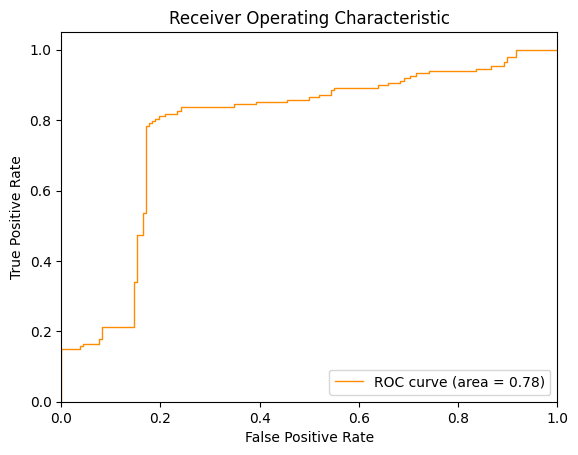

 45%|████▌     | 9/20 [02:13<02:46, 15.17s/it]

              precision    recall  f1-score   support

      Normal       0.81      0.58      0.68      5054
   Anomalous       0.66      0.85      0.74      4749

    accuracy                           0.71      9803
   macro avg       0.73      0.72      0.71      9803
weighted avg       0.73      0.71      0.71      9803

Precision: 0.65697579990255
Recall: 0.8517582648978732
F1 Score: 0.7417935081606455
Confusion Matrix: 
[[2942 2112]
 [ 704 4045]]
Precision: 0.65697579990255
Recall: 0.8517582648978732
F1 Score: 0.7417935081606455
Accuracy: 0.7127409976537794
---------
Evaluating model with threshold: 0.0031842105263157894


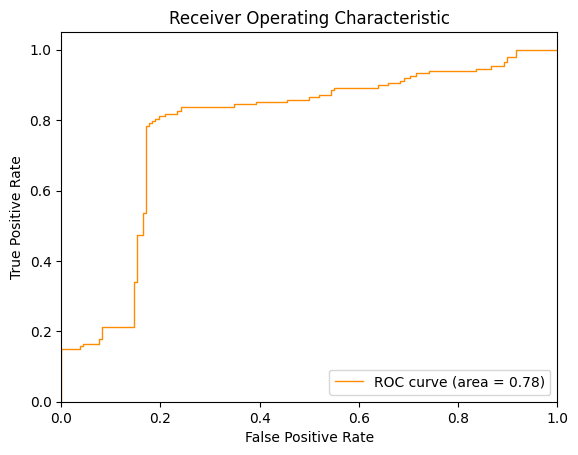

 50%|█████     | 10/20 [02:28<02:32, 15.26s/it]

              precision    recall  f1-score   support

      Normal       0.83      0.73      0.78      5054
   Anomalous       0.75      0.84      0.79      4749

    accuracy                           0.78      9803
   macro avg       0.79      0.79      0.78      9803
weighted avg       0.79      0.78      0.78      9803

Precision: 0.7476056338028169
Recall: 0.8382817435249527
F1 Score: 0.7903513996426444
Confusion Matrix: 
[[3710 1344]
 [ 768 3981]]
Precision: 0.7476056338028169
Recall: 0.8382817435249527
F1 Score: 0.7903513996426444
Accuracy: 0.7845557482403346
---------
Evaluating model with threshold: 0.0033157894736842103


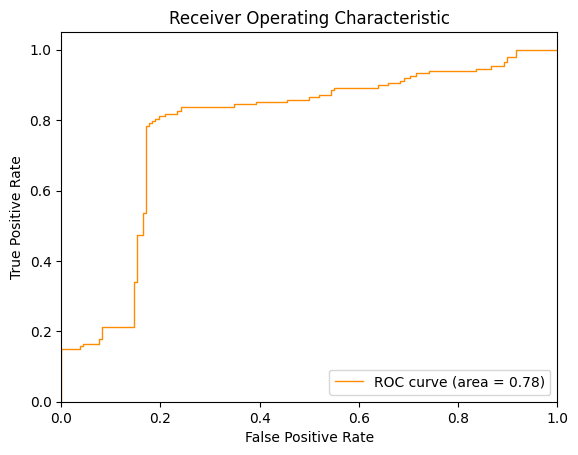

 55%|█████▌    | 11/20 [02:43<02:15, 15.04s/it]

              precision    recall  f1-score   support

      Normal       0.82      0.78      0.80      5054
   Anomalous       0.78      0.82      0.80      4749

    accuracy                           0.80      9803
   macro avg       0.80      0.80      0.80      9803
weighted avg       0.80      0.80      0.80      9803

Precision: 0.7812185803338025
Recall: 0.8180669614655717
F1 Score: 0.799218267846122
Confusion Matrix: 
[[3966 1088]
 [ 864 3885]]
Precision: 0.7812185803338025
Recall: 0.8180669614655717
F1 Score: 0.799218267846122
Accuracy: 0.8008772824645517
---------
Evaluating model with threshold: 0.0034473684210526313


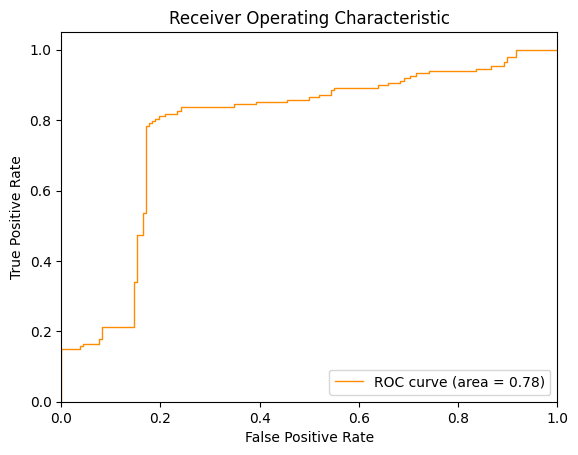

 60%|██████    | 12/20 [02:57<01:58, 14.82s/it]

              precision    recall  f1-score   support

      Normal       0.81      0.82      0.81      5054
   Anomalous       0.80      0.80      0.80      4749

    accuracy                           0.81      9803
   macro avg       0.81      0.81      0.81      9803
weighted avg       0.81      0.81      0.81      9803

Precision: 0.8032647869408522
Recall: 0.7978521794061908
F1 Score: 0.8005493344601733
Confusion Matrix: 
[[4126  928]
 [ 960 3789]]
Precision: 0.8032647869408522
Recall: 0.7978521794061908
F1 Score: 0.8005493344601733
Accuracy: 0.8074058961542385
---------
Evaluating model with threshold: 0.003578947368421052


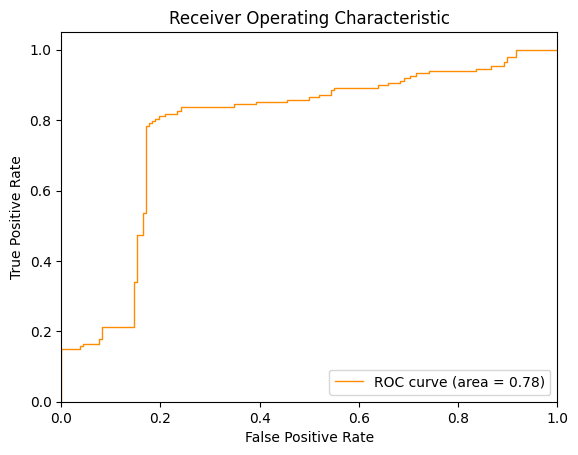

 65%|██████▌   | 13/20 [03:11<01:41, 14.50s/it]

              precision    recall  f1-score   support

      Normal       0.81      0.82      0.81      5054
   Anomalous       0.80      0.79      0.80      4749

    accuracy                           0.80      9803
   macro avg       0.80      0.80      0.80      9803
weighted avg       0.80      0.80      0.80      9803

Precision: 0.8019210245464248
Recall: 0.7911139187197305
F1 Score: 0.7964808140767436
Confusion Matrix: 
[[4126  928]
 [ 992 3757]]
Precision: 0.8019210245464248
Recall: 0.7911139187197305
F1 Score: 0.7964808140767436
Accuracy: 0.804141589309395
---------
Evaluating model with threshold: 0.003710526315789473


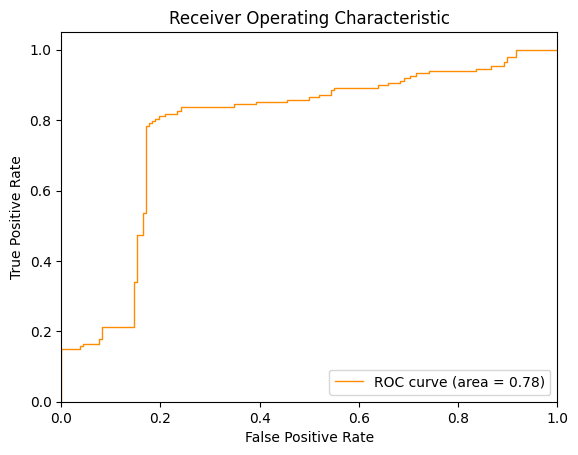

 70%|███████   | 14/20 [03:25<01:25, 14.28s/it]

              precision    recall  f1-score   support

      Normal       0.80      0.82      0.81      5054
   Anomalous       0.81      0.78      0.80      4749

    accuracy                           0.80      9803
   macro avg       0.80      0.80      0.80      9803
weighted avg       0.80      0.80      0.80      9803

Precision: 0.8061025752001731
Recall: 0.7843756580332701
F1 Score: 0.7950907150480256
Confusion Matrix: 
[[4158  896]
 [1024 3725]]
Precision: 0.8061025752001731
Recall: 0.7843756580332701
F1 Score: 0.7950907150480256
Accuracy: 0.804141589309395
---------
Evaluating model with threshold: 0.003842105263157894


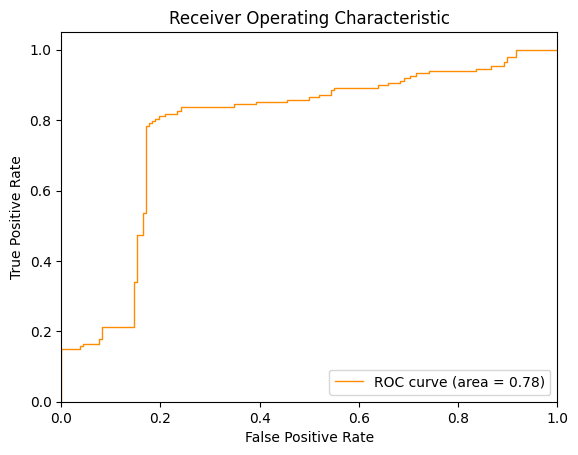

 75%|███████▌  | 15/20 [03:38<01:10, 14.12s/it]

              precision    recall  f1-score   support

      Normal       0.80      0.83      0.82      5054
   Anomalous       0.81      0.78      0.80      4749

    accuracy                           0.81      9803
   macro avg       0.81      0.81      0.81      9803
weighted avg       0.81      0.81      0.81      9803

Precision: 0.8117236870777947
Recall: 0.7843756580332701
F1 Score: 0.7978153780252731
Confusion Matrix: 
[[4190  864]
 [1024 3725]]
Precision: 0.8117236870777947
Recall: 0.7843756580332701
F1 Score: 0.7978153780252731
Accuracy: 0.8074058961542385
---------
Evaluating model with threshold: 0.003973684210526315


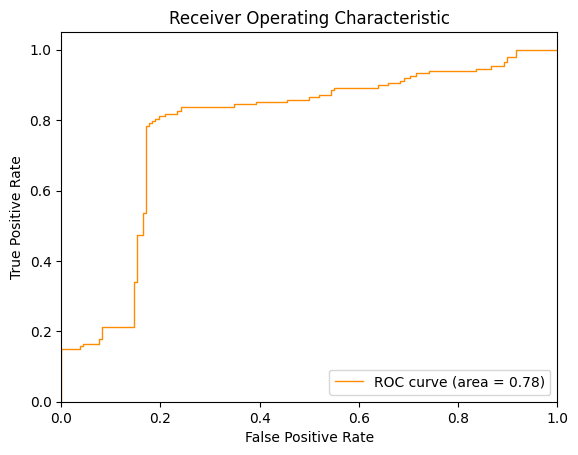

 80%|████████  | 16/20 [03:52<00:56, 14.03s/it]

              precision    recall  f1-score   support

      Normal       0.80      0.83      0.82      5054
   Anomalous       0.81      0.78      0.80      4749

    accuracy                           0.81      9803
   macro avg       0.81      0.81      0.81      9803
weighted avg       0.81      0.81      0.81      9803

Precision: 0.8117236870777947
Recall: 0.7843756580332701
F1 Score: 0.7978153780252731
Confusion Matrix: 
[[4190  864]
 [1024 3725]]
Precision: 0.8117236870777947
Recall: 0.7843756580332701
F1 Score: 0.7978153780252731
Accuracy: 0.8074058961542385
---------
Evaluating model with threshold: 0.004105263157894737


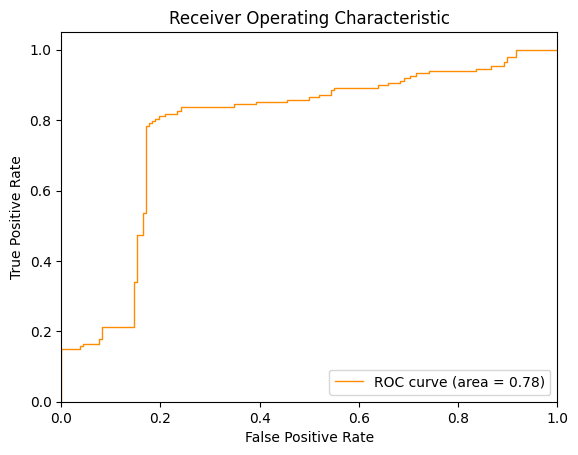

 85%|████████▌ | 17/20 [04:06<00:42, 14.08s/it]

              precision    recall  f1-score   support

      Normal       0.80      0.83      0.81      5054
   Anomalous       0.81      0.78      0.79      4749

    accuracy                           0.80      9803
   macro avg       0.80      0.80      0.80      9803
weighted avg       0.80      0.80      0.80      9803

Precision: 0.8104015799868335
Recall: 0.7776373973468098
F1 Score: 0.7936814958091553
Confusion Matrix: 
[[4190  864]
 [1056 3693]]
Precision: 0.8104015799868335
Recall: 0.7776373973468098
F1 Score: 0.7936814958091553
Accuracy: 0.804141589309395
---------
Evaluating model with threshold: 0.004236842105263157


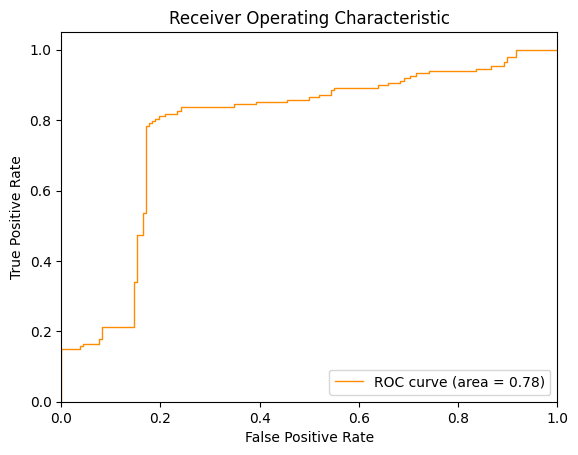

 90%|█████████ | 18/20 [04:21<00:28, 14.37s/it]

              precision    recall  f1-score   support

      Normal       0.79      0.83      0.81      5054
   Anomalous       0.81      0.77      0.79      4749

    accuracy                           0.80      9803
   macro avg       0.80      0.80      0.80      9803
weighted avg       0.80      0.80      0.80      9803

Precision: 0.809060773480663
Recall: 0.7708991366603496
F1 Score: 0.7895190856156998
Confusion Matrix: 
[[4190  864]
 [1088 3661]]
Precision: 0.809060773480663
Recall: 0.7708991366603496
F1 Score: 0.7895190856156998
Accuracy: 0.8008772824645517
---------
Evaluating model with threshold: 0.004368421052631579


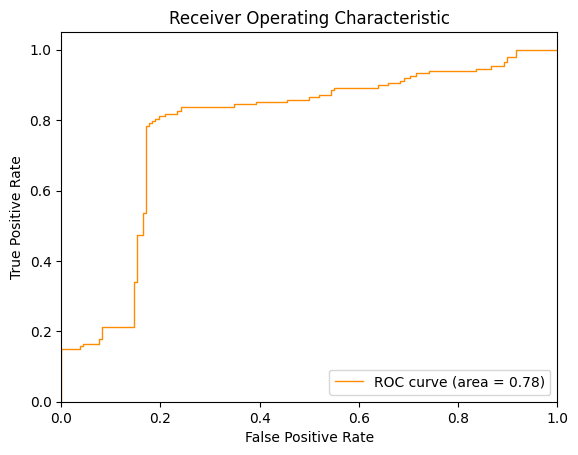

 95%|█████████▌| 19/20 [04:36<00:14, 14.53s/it]

              precision    recall  f1-score   support

      Normal       0.78      0.83      0.81      5054
   Anomalous       0.81      0.76      0.78      4749

    accuracy                           0.79      9803
   macro avg       0.80      0.79      0.79      9803
weighted avg       0.79      0.79      0.79      9803

Precision: 0.8063214525891056
Recall: 0.7574226152874289
F1 Score: 0.7811074918566776
Confusion Matrix: 
[[4190  864]
 [1152 3597]]
Precision: 0.8063214525891056
Recall: 0.7574226152874289
F1 Score: 0.7811074918566776
Accuracy: 0.7943486687748649
---------
Evaluating model with threshold: 0.0045


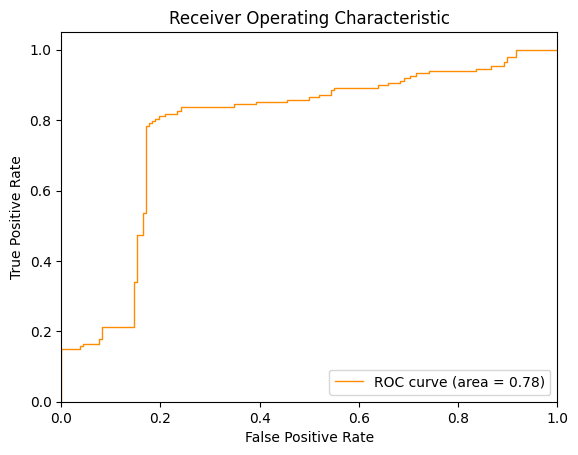

100%|██████████| 20/20 [04:51<00:00, 14.59s/it]

              precision    recall  f1-score   support

      Normal       0.75      0.83      0.79      5054
   Anomalous       0.80      0.71      0.75      4749

    accuracy                           0.77      9803
   macro avg       0.77      0.77      0.77      9803
weighted avg       0.77      0.77      0.77      9803

Precision: 0.7960821335850838
Recall: 0.7102547904822067
F1 Score: 0.7507233474293346
Confusion Matrix: 
[[4190  864]
 [1376 3373]]
Precision: 0.7960821335850838
Recall: 0.7102547904822067
F1 Score: 0.7507233474293346
Accuracy: 0.7714985208609609
---------


In [134]:
# Initialize some lists to keep track of metrics
precisions = []
recalls = []
f1_scores = []
accuracies = []

# Generate 20 evenly spaced threshold values between 0.002 and 0.0045
thresholds = np.linspace(0.002, 0.0045, 20)

for threshold in tqdm(thresholds):
    print(f"Evaluating model with threshold: {threshold}")
    cm, precision, recall, f1 = generate_metrics(model, criterion, device, normal_loader, anomalous_loader, threshold)

    accuracy = (cm[0,0] + cm[1,1]) / np.sum(cm)

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    accuracies.append(accuracy)

    print(f"Confusion Matrix: \n{cm}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Accuracy: {accuracy}")
    print("---------")

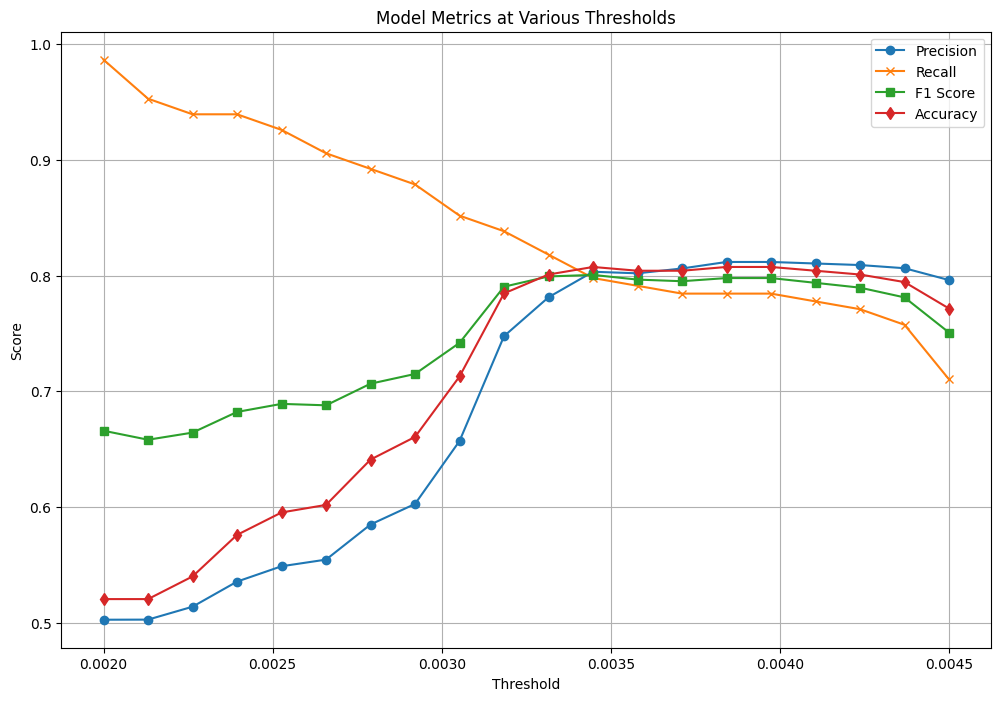

In [135]:
plt.figure(figsize=(12, 8))

# Plotting
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='x')
plt.plot(thresholds, f1_scores, label='F1 Score', marker='s')
plt.plot(thresholds, accuracies, label='Accuracy', marker='d')

# Labeling and Legends
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Model Metrics at Various Thresholds')
plt.legend()
plt.grid(True)

plt.show()